In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install xgboost


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

sns.set_style("whitegrid")


In [5]:
from google.colab import files

uploaded = files.upload()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [6]:
df = pd.read_csv(list(uploaded.keys())[0])

print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [10]:
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [11]:
df.replace(" ", np.nan, inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df.dropna(inplace=True)

df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


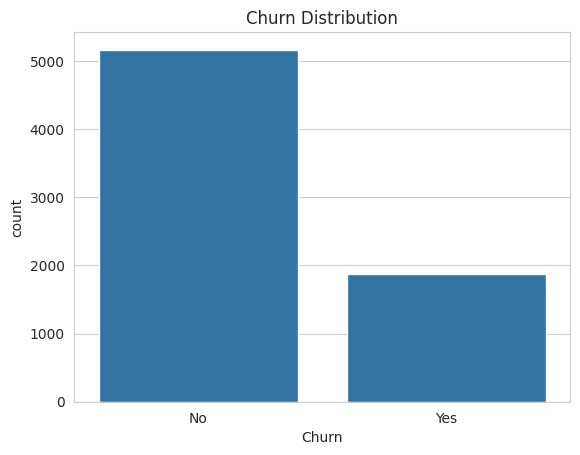

In [12]:
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()


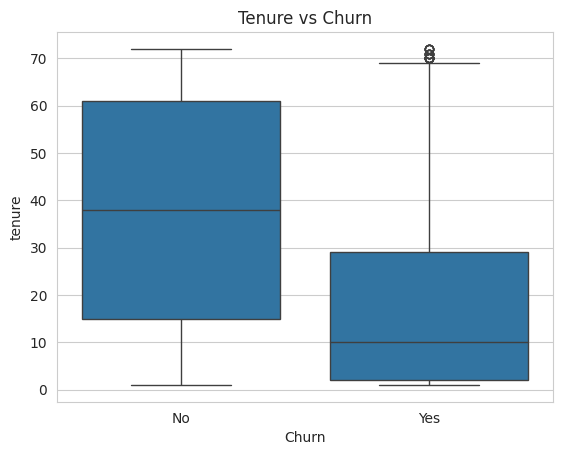

In [13]:
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()


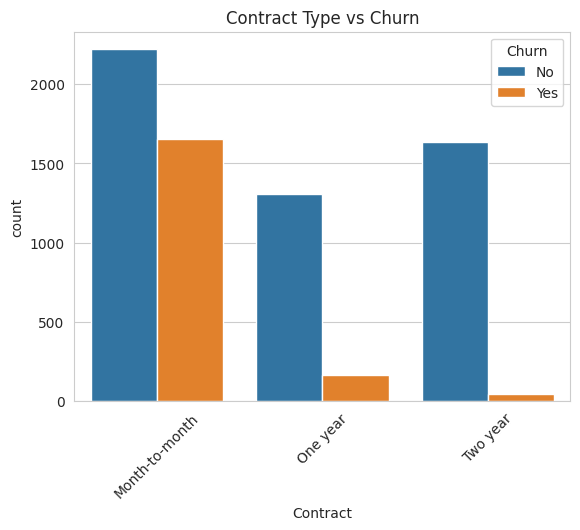

In [14]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.xticks(rotation=45)
plt.title("Contract Type vs Churn")
plt.show()


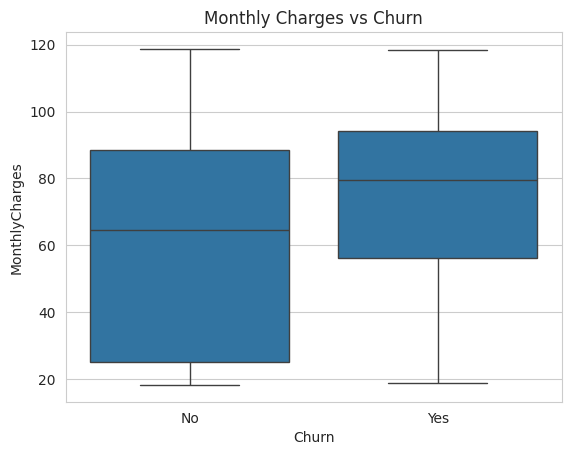

In [15]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


In [16]:
cat_cols = df.select_dtypes(include="object").columns
cat_cols = cat_cols.drop(["customerID", "Churn"])

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [17]:
X = df_encoded.drop("Churn", axis=1)

y = df_encoded["Churn"].apply(lambda x: 1 if x == "Yes" else 0)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [20]:
# Check for non-numeric columns
X.dtypes[X.dtypes == "object"]


,0
customerID,object


In [21]:
# Make sure customerID is removed
if "customerID" in X.columns:
    X = X.drop("customerID", axis=1)

# Re-split after fixing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

    trained_models[name] = model


In [24]:
results_df = pd.DataFrame(results).T
results_df


,Accuracy,Recall,ROC-AUC
Logistic Regression,0.803838,0.574866,0.835673
Random Forest,0.786780,0.502674,0.817219
XGBoost,0.778252,0.548128,0.819670


In [25]:
best_model_name = results_df["ROC-AUC"].idxmax()
best_model = trained_models[best_model_name]

print("Best Model:", best_model_name)


Best Model: Logistic Regression


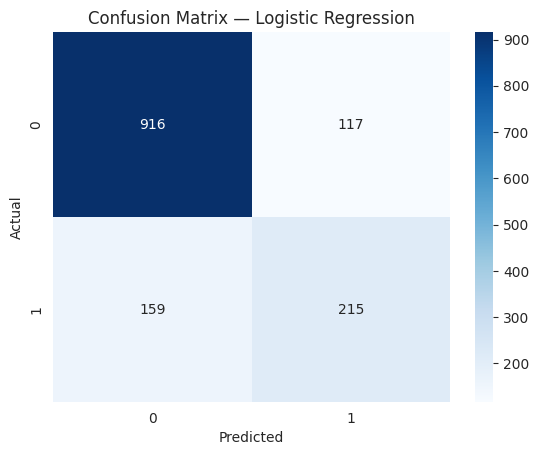

In [26]:
y_pred_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


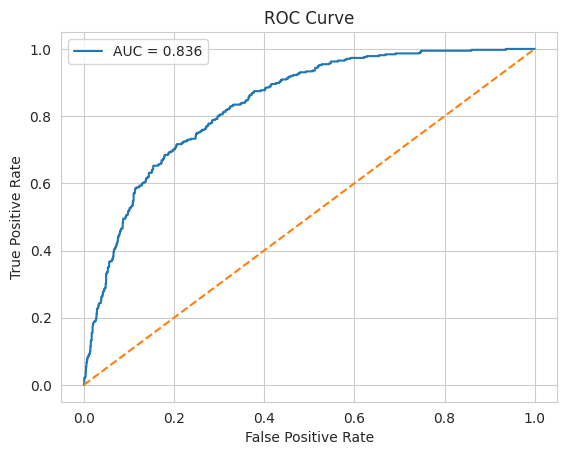

In [27]:
y_prob_best = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob_best)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_best):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
m

In [30]:
import joblib

joblib.dump(best_model, "best_churn_model.pkl")


['best_churn_model.pkl']